## Attention LSTM 
    - Validation data used
    - 30 day lag is used as additonal col for y   [<x> -> y(t-30)]
    - Forecast using Attention LSTM
    - Dropouts are added
    - Scaled Training Data

In [2]:
from random import randint
from numpy import array
from numpy import argmax
from numpy import array_equal
from keras.models import Sequential
from keras.layers import LSTM
# from attention_decoder import AttentionDecoder

Using TensorFlow backend.


In [3]:
import pandas as pd
from sklearn .preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM

In [4]:
from math import sqrt
from numpy import split
from numpy import array
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

In [10]:
from matplotlib import pyplot as plt
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
pd.options.display.float_format = '{:,.10f}'.format
import matplotlib.pyplot as plt

In [6]:
from numpy import loadtxt
from keras.models import load_model  
from keras.utils.vis_utils import plot_model

In [7]:
data  = pd.read_excel('emotion.xls').drop('Date', axis=1 ).set_index("day")

In [8]:
data = data.astype('float32')

In [45]:
data_vol =  data.iloc[ : , 0:13].drop(['Close_nifty', 'Close_sensex','% change_nifty', '% change_sensex'], axis= 1)

**DATA PREP**

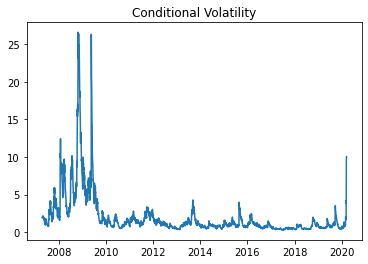

In [46]:
plt.plot(data_vol['Conditional Volatility'])
plt.title('Conditional Volatility')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [47]:
data_vol['lag30'] = data_vol['Conditional Volatility'].shift(-30)

In [12]:
# data_vol = data_vol.dropna()

In [48]:
data_vol.tail()

,Anger,Anticipation,Disgust,Fear,Joy,Sadness,Surprise,Trust,Conditional Volatility,lag30
day,,,,,,,,,,
2020-03-09,48.7620010376,106.4359970093,24.3150005341,112.8659973145,67.8519973755,63.9239997864,29.7049999237,191.4120025635,1.9670089483,nan
2020-03-11,50.3549995422,116.0370025635,29.6329994202,89.9520034790,82.4400024414,61.6689987183,33.7290000916,207.7250061035,4.1832318306,nan
2020-03-12,50.9729995728,81.4199981689,9.0970001221,109.1880035400,56.3889999390,82.7139968872,19.9899997711,155.2369995117,3.8387451172,nan
2020-03-13,43.6920013428,88.3270034790,13.2220001221,108.8079986572,70.9550018311,77.8160018921,31.1870002747,159.1920013428,9.6012992859,nan
2020-03-16,34.8849983215,72.6279983521,14.6059999466,74.0149993896,40.5110015869,45.2589988708,23.5279998779,125.6699981689,10.0432195663,nan


In [57]:
train, test = data_vol[18:-60] , data_vol[-60:]

In [58]:
print(len(train))
print(len(test))

3090
60


In [59]:
scaler = MinMaxScaler()
train = pd.DataFrame(scaler.fit_transform(train), columns=train.columns, index=train.index)

In [60]:
yscaler = MinMaxScaler()
df = pd.DataFrame(train.iloc[:, -1])
df = yscaler.fit_transform(yscaler.fit_transform(df) )

In [67]:
train = array(split(train.values, len(train)/30))
test = array(split(test.values, len(test)/30))

In [68]:
def to_supervised(train, n_input, n_out=30):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	val_x, val_y = list(), list()
	in_start = 0
	for _ in range(len(data)):
		in_end = in_start + n_input
		out_end = in_end + n_out
		if out_end <= len(data):
			X.append(data[in_start:in_end, :-1])
			y.append(data[in_start:in_end, -1:])
			val_x.append(data[in_end:out_end, :-1])
			val_y.append(data[in_end:out_end, -1:])
		in_start += 1
	return array(X), array(y), array(val_x), array(val_y)

**MODEL**

In [69]:
from keras.layers.core import Layer  
from keras import initializers, regularizers, constraints  
from keras import backend as K

In [70]:
from keras import backend as K, initializers, regularizers, constraints
from keras.engine.topology import Layer

def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        # todo: check that this is correct
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)


class Attention(Layer):
    def __init__(self,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True,
                 return_attention=False,
                 **kwargs):
        """
        Keras Layer that implements an Attention mechanism for temporal data.
        Supports Masking.
        Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        Note: The layer has been tested with Keras 1.x
        Example:
        
            # 1
            model.add(LSTM(64, return_sequences=True))
            model.add(Attention())
            # next add a Dense layer (for classification/regression) or whatever...
            # 2 - Get the attention scores
            hidden = LSTM(64, return_sequences=True)(words)
            sentence, word_scores = Attention(return_attention=True)(hidden)
        """
        self.supports_masking = True
        self.return_attention = return_attention
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape = (input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape = (input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        eij = dot_product(x, self.W)

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        weighted_input = x * K.expand_dims(a)

        result = K.sum(weighted_input, axis=1)

        if self.return_attention:
            return [result, a]
        return result

    def compute_output_shape(self, input_shape):
        if self.return_attention:
            return [(input_shape[0], input_shape[-1]),
                    (input_shape[0], input_shape[1])]
        else:
            return input_shape[0], input_shape[-1]

In [71]:
def build_model(train, n_input):
	train_x, train_y, val_x, val_y = to_supervised(train, n_input)
	verbose, epochs, batch_size = 1, 400, 300
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	print(train_x.shape)
	print(train_y.shape)
    
	units= 200
	model = Sequential() 
	model.add(LSTM(units, activation='relu', input_shape=(n_timesteps, n_features), return_sequences = True))#output:(none, timesteps,units)
	model.add(Attention())
	model.add(RepeatVector(n_outputs))
	model.add(Dense(1))
	model.compile(loss='mse', optimizer='adam',   metrics=['accuracy', 'mse',"mean_squared_logarithmic_error", 'mae', 'mape'])
	model.summary()

	# fit network
	history = model.fit(train_x, train_y, epochs=epochs, validation_data=(val_x, val_y), batch_size=batch_size, verbose=verbose)
	return model, history

In [72]:
n_input = 30 
model, history = build_model(train, n_input) 
model.save( 'model10' + '.h5')
print("model saved10") 

(3031, 30, 9)
(3031, 30, 1)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 30, 200)           168000    
_________________________________________________________________
attention_2 (Attention)      (None, 200)               230       
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 30, 200)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 30, 1)             201       
Total params: 168,431
Trainable params: 168,431
Non-trainable params: 0
_________________________________________________________________
Train on 3031 samples, validate on 3031 samples
Epoch 1/400
3031/3031 [==============================] - 10s 3ms/step - loss: 0.0118 - accuracy: 3.2992e-04 - mse: 0.0118 - mean_squared_logarithmic_error: 0.0073 - mae: 

In [73]:
print(history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'val_mse', 'val_mean_squared_logarithmic_error', 'val_mae', 'val_mape', 'loss', 'accuracy', 'mse', 'mean_squared_logarithmic_error', 'mae', 'mape'])


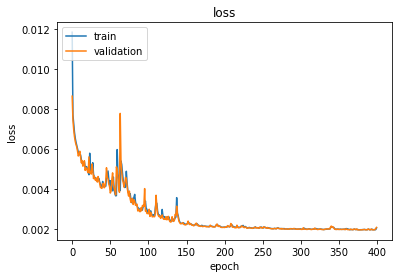

In [74]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

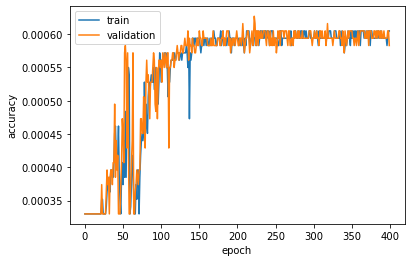

In [75]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

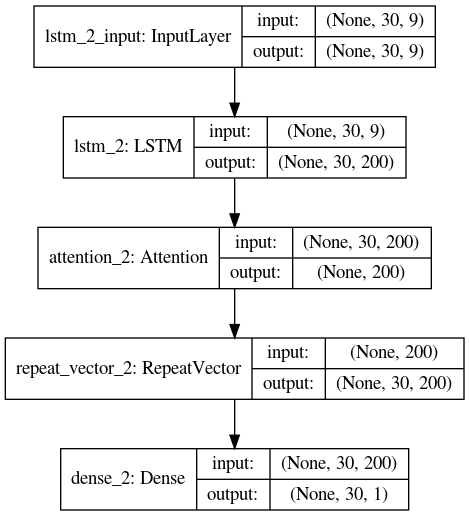

In [76]:
dot_img_file = 'AttentionLSTM.png'
plot_model(model, to_file=dot_img_file, show_shapes=True, show_layer_names=True)

## Forecast

In [77]:
test.shape

(2, 30, 10)

In [61]:
test1 = test.reshape((test.shape[0]*test.shape[1], test.shape[2]))
test1.shape

(30, 10)

In [87]:
def make_test_data(test, n_input):
	# flatten data
	data = test.reshape((test.shape[0]*test.shape[1], test.shape[2]))
	X, actual = list(), list()
	in_start = 0
	for _ in range(len(data)):
		in_end = in_start + n_input
		if in_end < len(data):
			X.append(data[in_start:in_end, :-1])
			actual.append(data[in_start:in_start+1 , -1:])
		in_start += 1
	return array(X), array(actual)

In [132]:
input_x , actual = make_test_data(test, 30)

In [133]:
print(input_x.shape)
print(actual.shape)

(30, 30, 9)
(30, 1, 1)


In [134]:
#forecast the values
yhat = model.predict(input_x, verbose=1, batch_size= 30)

30/30 [==============================] - 0s 2ms/step


In [135]:
yhat[0].shape

(30, 1)

In [136]:
actual = actual.reshape(1,actual.shape[0])
predictions = yhat[0].reshape(1, yhat[0].shape[0])

In [137]:
predictions

array([[-1.2996389, -1.2996389, -1.2996389, -1.2996389, -1.2996389,
        -1.2996389, -1.2996389, -1.2996389, -1.2996389, -1.2996389,
        -1.2996389, -1.2996389, -1.2996389, -1.2996389, -1.2996389,
        -1.2996389, -1.2996389, -1.2996389, -1.2996389, -1.2996389,
        -1.2996389, -1.2996389, -1.2996389, -1.2996389, -1.2996389,
        -1.2996389, -1.2996389, -1.2996389, -1.2996389, -1.2996389]],
      dtype=float32)

In [117]:
predictions = yscaler.inverse_transform(predictions)

In [118]:
predictions # same values are outputted 

array([[-1.2996389, -1.2996389, -1.2996389, -1.2996389, -1.2996389,
        -1.2996389, -1.2996389, -1.2996389, -1.2996389, -1.2996389,
        -1.2996389, -1.2996389, -1.2996389, -1.2996389, -1.2996389,
        -1.2996389, -1.2996389, -1.2996389, -1.2996389, -1.2996389,
        -1.2996389, -1.2996389, -1.2996389, -1.2996389, -1.2996389,
        -1.2996389, -1.2996389, -1.2996389, -1.2996389, -1.2996389]],
      dtype=float32)

In [101]:
def evaluate_forecasts_new(actual, predicted):
	scores = list()
	for i in range(actual.shape[1]):
		mse = mean_squared_error(actual[:, i], predicted[: , i])
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
        
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [102]:
score, scores = evaluate_forecasts_new(actual, predictions)

In [103]:
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))
    
summarize_scores('test', score, scores)

test: [3.949] 1.9, 2.4, 2.3, 2.6, 2.6, 2.5, 2.4, 2.3, 2.3, 2.3, 2.2, 2.2, 2.1, 2.1, 2.1, 2.1, 2.4, 2.3, 2.3, 2.2, 3.3, 3.2, 3.2, 3.0, 2.9, 3.3, 5.5, 5.1, 10.9, 11.3


### **References** :

To implement Attention Mechanism I used the [source code](https://gist.github.com/cbaziotis/6428df359af27d58078ca5ed9792bd6d) of Christos Baziotis. A few changes very made to debug errors [using this gist comment](https://gist.github.com/cbaziotis/6428df359af27d58078ca5ed9792bd6d#gistcomment-3094589 )

[Metrics in model.compile](https://machinelearningmastery.com/custom-metrics-deep-learning-keras-python/)